In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import roc_auc_score, average_precision_score
import matplotlib.pyplot as plt

In [2]:
drugs = ['RIFAMPICIN', 'ISONIAZID',
             'ETHAMBUTOL', 'LEVOFLOXACIN',
             'AMIKACIN', 'MOXIFLOXACIN',
             'KANAMYCIN', 'ETHIONAMIDE',
             ]
num_drugs = len(drugs)
first_line = ["RIFAMPICIN", "ISONIAZID", "ETHAMBUTOL"]

original_drugs =  ['RIFAMPICIN', 'ISONIAZID', 'PYRAZINAMIDE',
             'ETHAMBUTOL', 'STREPTOMYCIN', 'LEVOFLOXACIN',
             'CAPREOMYCIN', 'AMIKACIN', 'MOXIFLOXACIN',
             'OFLOXACIN', 'KANAMYCIN', 'ETHIONAMIDE',
             'CIPROFLOXACIN']

In [3]:
def rs_encoding_to_numeric(df_geno_pheno, drugs_list):
    """
	Creates a matrix of y values (resistance/sensitivity)
	to each drug, encoded as 0's and 1's
	Parameters
	----------
	df_geno_pheno: pd.DataFrame


	Returns
	-------
	pd.Dataframe

    np.ndarray

	"""

    y_all_rs = df_geno_pheno[drugs_list]
    y_all_rs = y_all_rs.fillna('-1')
    y_all_rs = y_all_rs.astype(str)
    resistance_categories = {'R': 0, 'S': 1, '-1.0': -1, '-1': -1, "I": -1}

    y_all = y_all_rs.copy()
    for key, val in resistance_categories.items():
        y_all[y_all_rs == key] = val

    y_all.index = list(range(0, y_all.shape[0]))

    y_all_array = y_all.values

    return y_all, y_all_array
def compute_drug_auc_table(y_train, y_train_pred, drug_to_threshold):
        """
        Computes the AUC, sensitivity, specificity, for given threshold

        Parameters
        ----------
        y_train: np.array
            actual values for y
        y_train_pred: np.array
            predicted values for y
        drug_to_threshold: dict of str->float
            The prediction threshold for each drug
        Returns
        -------
        pd.DataFrame with columns: 'Algorithm', 'Drug', "num_sensitive", "num_resistant",'AUC', "threshold", "spec", "sens"
        """
        column_names = ['Algorithm', 'Drug', "num_sensitive", "num_resistant",'AUC', "threshold", "spec", "sens"]
        results = pd.DataFrame(columns=column_names)

        for idx, drug in enumerate(original_drugs):
            if not drug in drugs:
                continue

            new_idx = drugs.index(drug)

            #print("evaluating for the test set,", drug, idx, new_idx)

            # Calculate the threshold from the TRAINING data, not the test data
            val_threshold = float(drug_to_threshold[drug])

            non_missing_val = np.where(y_train[:, new_idx] != -1)[0]
            # If we don't have any phenotypes, we can't assess
            if len(non_missing_val)==0:
                results.loc[idx] = ['MD-CNN', drug, 0, 0, np.nan, val_threshold, np.nan, np.nan]
                continue

            # Input data must be indexed with new_idx, output data must be indexed with idx
            # (Model still predicts for all drugs)
            auc_y = np.reshape(y_train[non_missing_val, new_idx], (len(non_missing_val), 1)).astype(int)
            auc_preds = np.reshape(y_train_pred[non_missing_val, new_idx], (len(non_missing_val), 1))
            #print(set(list(auc_y.reshape(1,-1)[0])), auc_preds)
            num_sensitive = np.sum(auc_y==1)
            num_resistant = np.sum(auc_y==0)

            # If we don't have at least 1 R and 1 S isolate we can't assess model
            if num_sensitive==0 or num_resistant==0:
                results.loc[idx] = ['MD-CNN', drug, num_sensitive, num_resistant, np.nan, val_threshold, np.nan, np.nan]
                continue

            # Compute the AUC
            val_auc = roc_auc_score(auc_y, auc_preds)

            # Binarize the predicted values
            binary_prediction = np.array(y_train_pred[non_missing_val, new_idx] > val_threshold).astype(int)

            # Remember that in RS encoding to numeric, resistant==0
            # Specificity = #TN / # Condition Negative
            val_spec = np.sum(np.logical_and(binary_prediction == 1, y_train[non_missing_val, new_idx] == 1)) / num_sensitive

            # Sensitivity = #TP / # Condition Positive, Here defining "positive" as resistant
            val_sens = np.sum(np.logical_and(binary_prediction == 0, y_train[non_missing_val, new_idx] == 0)) / num_resistant

            results.loc[idx] = ['MD-CNN', drug, num_sensitive, num_resistant, val_auc,  val_threshold, val_spec, val_sens]

        return results


## MD-CNN

In [4]:
all_df = pd.read_csv("MDCNN_cryptic_accuracy_strain_auc.csv")
all_df = all_df.rename({drug:drug+"_prediction" for drug in drugs}, axis=1)
## Add the actual resistance information

cryptic_data = pd.read_csv('cryptic_dataset.csv', index_col=0)
# Subsetting so that we only have RIF phenotyped isolates

all_df = all_df.merge(cryptic_data[["UNIQUEID", "ROLLINGDB_ID"] + drugs], left_on="Isolate", right_on="UNIQUEID", how="left")
#all_df = all_df.dropna(subset=["RIFAMPICIN"])
all_df
# y_train = np.load("actual_y_cryptic.npy", allow_pickle=True)
# y_train_pred = np.load("predicted_y_cryptic.npy")
# print("shape of the training data", y_train.shape)

,Unnamed: 0,Isolate,RIFAMPICIN_prediction,ISONIAZID_prediction,PYRAZINAMIDE,ETHAMBUTOL_prediction,STREPTOMYCIN,LEVOFLOXACIN_prediction,CAPREOMYCIN,AMIKACIN_prediction,...,UNIQUEID,ROLLINGDB_ID,RIFAMPICIN,ISONIAZID,ETHAMBUTOL,LEVOFLOXACIN,AMIKACIN,MOXIFLOXACIN,KANAMYCIN,ETHIONAMIDE
0,ERR2510878,site.06.subj.06TB_0115.lab.06MIL1028.iso.1,0.021395,0.028076,0.319680,0.163246,0.008417,0.997756,0.906759,0.787656,...,site.06.subj.06TB_0115.lab.06MIL1028.iso.1,ERR2510878,NaN,R,S,S,S,NaN,S,S
1,ERR2510875,site.06.subj.06TB_0434.lab.06MIL1025.iso.1,0.013104,0.018577,0.319541,0.047271,0.244366,0.871286,0.037586,0.007412,...,site.06.subj.06TB_0434.lab.06MIL1025.iso.1,ERR2510875,R,R,R,NaN,R,NaN,R,S
2,ERR2510870,site.06.subj.SSM_0098-14.lab.06MIL0016.iso.1,0.008292,0.009481,0.056190,0.051163,0.065533,0.221393,0.828555,0.770309,...,site.06.subj.SSM_0098-14.lab.06MIL0016.iso.1,ERR2510870,R,R,R,R,S,NaN,S,S
3,ERR2510869,site.06.subj.06TB_0428.lab.06MIL1019.iso.1,0.020791,0.027393,0.251460,0.096939,0.023895,0.935879,0.370264,0.376400,...,site.06.subj.06TB_0428.lab.06MIL1019.iso.1,ERR2510869,R,R,I,NaN,S,NaN,S,R
4,ERR2510860,site.06.subj.PIMS_0043-14.lab.06MIL0244.iso.1,0.030907,0.303089,0.794436,0.643862,0.560189,0.699101,0.933467,0.504140,...,site.06.subj.PIMS_0043-14.lab.06MIL0244.iso.1,ERR2510860,R,R,I,S,S,S,S,NaN
5,ERR2510854,site.06.subj.06TB_0413.lab.06MIL1004.iso.1,0.015043,0.023210,0.469886,0.487013,0.003359,0.995614,0.777340,0.587784,...,site.06.subj.06TB_0413.lab.06MIL1004.iso.1,ERR2510854,R,R,NaN,S,S,S,R,NaN
6,ERR2510842,site.06.subj.06TB_0401.lab.06MIL0992.iso.1,0.010019,0.010071,0.365278,0.328715,0.259321,0.939734,0.783616,0.423283,...,site.06.subj.06TB_0401.lab.06MIL0992.iso.1,ERR2510842,R,R,NaN,NaN,NaN,NaN,NaN,NaN
7,ERR2510841,site.06.subj.06TB_0390.lab.06MIL0986.iso.1,0.018109,0.028360,0.367323,0.340248,0.016398,0.189887,0.747065,0.624005,...,site.06.subj.06TB_0390.lab.06MIL0986.iso.1,ERR2510841,R,R,S,R,S,R,S,S
8,ERR2510840,site.06.subj.06TB_0399.lab.06MIL0990.iso.1,0.032782,0.031641,0.139656,0.088735,0.011796,0.287684,0.048374,0.010841,...,site.06.subj.06TB_0399.lab.06MIL0990.iso.1,ERR2510840,R,NaN,R,R,R,R,R,R
9,ERR2510734,site.06.subj.06TB_0293.lab.06MIL0884.iso.1,0.013104,0.018577,0.319541,0.047271,0.244366,0.871286,0.037586,0.007412,...,site.06.subj.06TB_0293.lab.06MIL0884.iso.1,ERR2510734,R,R,NaN,NaN,R,S,R,S


In [5]:
## removing the isolates with failed Kraken runs from both arrays
kraken_failed = pd.read_csv("failed_classification.txt", header=None)
kraken_failed = set(kraken_failed[0])
all_df = all_df.query("not ROLLINGDB_ID in @kraken_failed")
print(all_df.shape)
_, y_train= rs_encoding_to_numeric(all_df, drugs)
y_train_pred = all_df[[f"{drug}_prediction" for drug in drugs]].values
print(y_train.shape, y_train_pred.shape)


(8292, 25)
(8292, 8) (8292, 8)


In [6]:
threshold_data = pd.read_csv("MDCNN_model_thresholds.csv")
drug_to_threshold = {x:y for x,y in zip(threshold_data.drug, threshold_data.threshold)}
drug_to_threshold

{'RIFAMPICIN': 0.58,
 'ISONIAZID': 0.65,
 'PYRAZINAMIDE': 0.51,
 'ETHAMBUTOL': 0.64,
 'STREPTOMYCIN': 0.36,
 'LEVOFLOXACIN': 0.54,
 'CAPREOMYCIN': 0.55,
 'AMIKACIN': 0.4,
 'MOXIFLOXACIN': 0.49,
 'OFLOXACIN': 0.56,
 'KANAMYCIN': 0.48,
 'ETHIONAMIDE': 0.52,
 'CIPROFLOXACIN': 0.35000000000000003}

In [8]:
!mkdir sampling_experiment_v4
mdcnn_complete = compute_drug_auc_table(y_train, 
                                 y_train_pred, 
                                 drug_to_threshold)
print(mdcnn_complete)



mkdir: sampling_experiment_v4: File exists
   Algorithm          Drug num_sensitive num_resistant       AUC  threshold  \
0     MD-CNN    RIFAMPICIN          4150          2791  0.976467       0.58   
1     MD-CNN     ISONIAZID          3711          3556  0.972886       0.65   
3     MD-CNN    ETHAMBUTOL          3840          1170  0.957620       0.64   
5     MD-CNN  LEVOFLOXACIN          5138           973  0.929126       0.54   
7     MD-CNN      AMIKACIN          6669           431  0.931827       0.40   
8     MD-CNN  MOXIFLOXACIN          4600           794  0.947757       0.49   
10    MD-CNN     KANAMYCIN          6658           550  0.917856       0.48   
11    MD-CNN   ETHIONAMIDE          5412           929  0.907187       0.52   

        spec      sens  
0   0.952771  0.976353  
1   0.945298  0.959505  
3   0.883333  0.956410  
5   0.977812  0.821172  
7   0.902834  0.853828  
8   0.924348  0.914358  
10  0.912436  0.800000  
11  0.914265  0.775027  


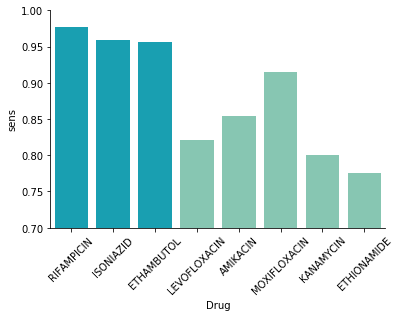

In [19]:
import seaborn as sns

color_indices = [0,0,0,1,1,1,1,1]
colors = np.array([
     "#00b3ca", "#7dd0b6"])
cmap = colors[color_indices]
sns.set_palette(sns.color_palette(cmap))

fig = plt.figure()
ax = fig.gca()

sns.barplot(data = mdcnn_complete, x = "Drug", y="sens")
plt.xticks(rotation = 45)
ax.set_ylim([0.7,1])
sns.despine()
plt.savefig("cryptic_MDCNN_sensitivity.pdf")

In [15]:
## Generate confidence intervals for MDCNN performance

interval = np.arange(0, y_train.shape[0])
all_samples = []

for i in range(100):
    indices = np.random.choice(interval, int(0.8*y_train.shape[0]), replace=False)
    mdcnn_sample = compute_drug_auc_table(y_train[indices,:], 
                                 y_train_pred[indices,:], 
                                 drug_to_threshold)
    mdcnn_sample["sample"] = i
    all_samples.append(mdcnn_sample)
    
all_samples_ = pd.concat(all_samples)
grouped = all_samples_.groupby("Drug")

medians = grouped.mean()
stds = grouped.std()

specificity_confidence_interval = 1.96 * stds.spec / np.sqrt(100)
sensitivity_confidence_interval = 1.96 * stds.sens / np.sqrt(100)
auc_confidence_interval = 1.96 * stds.AUC / np.sqrt(100)

specificity_confidence_interval, auc_confidence_interval, sensitivity_confidence_interval

medians["sens_CI_size"] = sensitivity_confidence_interval
medians["spec_CI_size"] = specificity_confidence_interval
medians["auc_CI_size"] = auc_confidence_interval

medians["sens_upper_bound"] = medians.sens + medians.sens_CI_size
medians["sens_lower_bound"] = medians.sens - medians.sens_CI_size
medians["spec_upper_bound"] = medians.spec + medians.sens_CI_size
medians["spec_lower_bound"] = medians.spec - medians.sens_CI_size
medians["Drug"] =medians.index

In [16]:
mdcnn_complete = mdcnn_complete.merge(medians[["Drug", "sens_upper_bound", "sens_lower_bound", "spec_upper_bound", "spec_lower_bound"]], left_on="Drug", right_index=True)
mdcnn_complete.to_csv("subsampling_experiment/mdcnn_complete.csv")

In [17]:
mdcnn_complete.query("Drug in @first_line").mean()

num_sensitive       3900.333333
num_resistant       2505.666667
AUC                    0.968991
threshold              0.623333
spec                   0.927134
sens                   0.964089
sens_upper_bound       0.964628
sens_lower_bound       0.963784
spec_upper_bound       0.927523
spec_lower_bound       0.926678
dtype: float64

In [18]:
mdcnn_complete.query("not Drug in @first_line").mean()

num_sensitive       5695.400000
num_resistant        735.400000
AUC                    0.926751
threshold              0.486000
spec                   0.926339
sens                   0.832877
sens_upper_bound       0.834581
sens_lower_bound       0.831645
spec_upper_bound       0.928002
spec_lower_bound       0.925066
dtype: float64

In [19]:
## Objective: sample rows of the training data such that the proportion of zeros in the first column is 5 percent
## This corresponds to 5% of sequenced isolates having RIF resistance

In [20]:
np.sum(y_train==1, axis=1)==0

array([False, False, False, ..., False, False, False])

In [21]:
y_where_sensitive = np.where(np.sum(y_train==0, axis=1)==0)[0]
print("Number of sensitive isolates", len(y_where_sensitive))

target_total_isolates = len(y_where_sensitive) / 0.95

num_R_to_sample = int(target_total_isolates) - len(y_where_sensitive)
print("number resistant to sample", num_R_to_sample)

y_where_resistant = np.where(y_train[:,0]==0)[0]

Number of sensitive isolates 4173
number resistant to sample 219


In [22]:
!mkdir sampling_experiment_v4
!mkdir subsampling_experiment/MDCNN
for i in range(100):

    sample = np.random.choice(y_where_resistant, num_R_to_sample, replace=False)
    
    full_sample = np.concatenate([y_where_sensitive, sample])

    results = compute_drug_auc_table(y_train[full_sample, :].astype(int), 
                                     y_train_pred[full_sample, :].astype(float), 
                                     drug_to_threshold)
    results["sample_number"] = i
    
    results.to_csv(f'subsampling_experiment/MDCNN/sample{i}.csv')

mkdir: sampling_experiment_v4: File exists
mkdir: sampling_experiment_v4/MDCNN: File exists


In [23]:
results

,Algorithm,Drug,num_sensitive,num_resistant,AUC,threshold,spec,sens,sample_number
0,MD-CNN,RIFAMPICIN,3337,219,0.967811,0.58,0.977225,0.963470,99
1,MD-CNN,ISONIAZID,3479,198,0.974469,0.65,0.971256,0.964646,99
3,MD-CNN,ETHAMBUTOL,2733,74,0.961207,0.64,0.974021,0.959459,99
5,MD-CNN,LEVOFLOXACIN,3159,72,0.946819,0.54,0.990187,0.847222,99
7,MD-CNN,AMIKACIN,3762,34,0.995989,0.40,0.983785,0.882353,99
8,MD-CNN,MOXIFLOXACIN,2743,55,0.948510,0.49,0.985417,0.927273,99
10,MD-CNN,KANAMYCIN,3776,44,0.995745,0.48,0.982786,0.863636,99
11,MD-CNN,ETHIONAMIDE,3424,55,0.938939,0.52,0.981893,0.800000,99


In [24]:

full_sample = np.concatenate([y_where_sensitive])

results = compute_drug_auc_table(y_train[full_sample, :].astype(int), 
                                 y_train_pred[full_sample, :].astype(float), 
                                 drug_to_threshold)
results

,Algorithm,Drug,num_sensitive,num_resistant,AUC,threshold,spec,sens
0,MD-CNN,RIFAMPICIN,3337,0,NaN,0.58,NaN,NaN
1,MD-CNN,ISONIAZID,3474,0,NaN,0.65,NaN,NaN
3,MD-CNN,ETHAMBUTOL,2696,0,NaN,0.64,NaN,NaN
5,MD-CNN,LEVOFLOXACIN,3075,0,NaN,0.54,NaN,NaN
7,MD-CNN,AMIKACIN,3602,0,NaN,0.40,NaN,NaN
8,MD-CNN,MOXIFLOXACIN,2644,0,NaN,0.49,NaN,NaN
10,MD-CNN,KANAMYCIN,3625,0,NaN,0.48,NaN,NaN
11,MD-CNN,ETHIONAMIDE,3321,0,NaN,0.52,NaN,NaN


In [25]:
## Computing summary statistics

_full_results = []

for i in range(100):
    x = pd.read_csv(f'subsampling_experiment/MDCNN/sample{i}.csv', index_col =0 )
    _full_results.append(x)
full_results = pd.concat(_full_results)
grouped = full_results.groupby("Drug")

# x +/- 1.96*std/sqrt(n)

medians = grouped.mean()
stds = grouped.std()

specificity_confidence_interval = 1.96 * stds.spec / np.sqrt(100)
sensitivity_confidence_interval = 1.96 * stds.sens / np.sqrt(100)
auc_confidence_interval = 1.96 * stds.AUC / np.sqrt(100)

specificity_confidence_interval, auc_confidence_interval, sensitivity_confidence_interval

medians["sens_CI_size"] = sensitivity_confidence_interval
medians["spec_CI_size"] = specificity_confidence_interval
medians["auc_CI_size"] = auc_confidence_interval

medians["sens_upper_bound"] = medians.sens + medians.sens_CI_size
medians["sens_lower_bound"] = medians.sens - medians.sens_CI_size
medians["spec_upper_bound"] = medians.spec + medians.sens_CI_size
medians["spec_lower_bound"] = medians.spec - medians.sens_CI_size

medians.to_csv("MDCNN_cryptic_subsampling_performance.csv")


## Comparing first and second line

In [26]:
## first_line vs second line

first_line = ["RIFAMPICIN", "ISONIAZID", "ETHAMBUTOL"]
fl = medians.query("Drug in @first_line")
fl.mean()

num_sensitive       3185.493333
num_resistant        164.746667
AUC                    0.983388
threshold              0.623333
spec                   0.974401
sens                   0.975740
sample_number         49.500000
sens_CI_size           0.002249
spec_CI_size           0.000159
auc_CI_size            0.001419
sens_upper_bound       0.977989
sens_lower_bound       0.973491
spec_upper_bound       0.976650
spec_lower_bound       0.972152
dtype: float64

In [27]:
sl= medians.query("not Drug in @first_line")
sl.mean()

num_sensitive       3377.308000
num_resistant         47.904000
AUC                    0.965348
threshold              0.486000
spec                   0.984839
sens                   0.866362
sample_number         49.500000
sens_CI_size           0.009566
spec_CI_size           0.000244
auc_CI_size            0.003647
sens_upper_bound       0.875927
sens_lower_bound       0.856796
spec_upper_bound       0.994405
spec_lower_bound       0.975273
dtype: float64

## SD-CNN


In [28]:


def compute_drug_auc_table_SDCNN(y_train, y_train_pred, drug_to_threshold):
        """
        Computes the AUC, sensitivity, specificity, for given threshold

        Parameters
        ----------
        y_train: np.array
            actual values for y
        y_train_pred: np.array
            predicted values for y
        drug_to_threshold: dict of str->float
            The prediction threshold for each drug
        Returns
        -------
        pd.DataFrame with columns: 'Algorithm', 'Drug', "num_sensitive", "num_resistant",'AUC', "threshold", "spec", "sens"
        """
        column_names = ['Algorithm', 'Drug', "num_sensitive", "num_resistant",'AUC', "threshold", "spec", "sens"]
        results = pd.DataFrame(columns=column_names)

        for idx, drug in enumerate(drugs):

            new_idx = drugs.index(drug)

            #print("evaluating for the test set,", drug, idx, new_idx)

            # Calculate the threshold from the TRAINING data, not the test data
            val_threshold = float(drug_to_threshold[drug])

            non_missing_val = np.where(y_train[:, new_idx] != -1)[0]
            # If we don't have any phenotypes, we can't assess
            if len(non_missing_val)==0:
                results.loc[idx] = ['SD-CNN', drug, 0, 0, np.nan, val_threshold, np.nan, np.nan]
                continue

            # Input data must be indexed with new_idx, output data must be indexed with idx
            # (Model still predicts for all drugs)
            auc_y = np.reshape(y_train[non_missing_val, new_idx], (len(non_missing_val), 1)).astype(int)
            auc_preds = np.reshape(y_train_pred[non_missing_val, idx], (len(non_missing_val), 1))
            
            #print(set(list(auc_y.reshape(1,-1)[0])), auc_preds)
            num_sensitive = np.sum(auc_y==1)
            num_resistant = np.sum(auc_y==0)

            # If we don't have at least 1 R and 1 S isolate we can't assess model
            if num_sensitive==0 or num_resistant==0:
                results.loc[idx] = ['SD-CNN', drug, num_sensitive, num_resistant, np.nan, val_threshold, np.nan, np.nan]
                continue

            # Compute the AUC
            val_auc = roc_auc_score(auc_y, auc_preds)

            # Binarize the predicted values
            binary_prediction = np.array(y_train_pred[non_missing_val, idx] > val_threshold).astype(int)

            # Remember that in RS encoding to numeric, resistant==0
            # Specificity = #TN / # Condition Negative
            val_spec = np.sum(np.logical_and(binary_prediction == 1, y_train[non_missing_val, new_idx] == 1)) / num_sensitive

            # Sensitivity = #TP / # Condition Positive, Here defining "positive" as resistant
            val_sens = np.sum(np.logical_and(binary_prediction == 0, y_train[non_missing_val, new_idx] == 0)) / num_resistant

            results.loc[idx] = ['SD-CNN', drug, num_sensitive, num_resistant, val_auc,  val_threshold, val_spec, val_sens]

        return results


In [29]:
# get the thresholds for SD-CNN results
abbrev_to_drug= {
    "AMI":"AMIKACIN",
    "RIF":"RIFAMPICIN",
    "INH":"ISONIAZID", 
    "ETA":"ETHIONAMIDE",
    "EMB":"ETHAMBUTOL",
    "LEVO":"LEVOFLOXACIN",
    "KAN":"KANAMYCIN",
    "MOXI":"MOXIFLOXACIN"
}

import glob
_dfs = []
for file in glob.glob("sdcnn_results/*drug_auc.csv"):
    df = pd.read_csv(file)
    df["abbrev"] = file.split("/")[-1].split("_")[0]
    _dfs.append(df)
    
threshold_data = pd.concat(_dfs)
threshold_data["drug"] = [abbrev_to_drug[x] for x in threshold_data.abbrev]
drug_to_threshold = {x:y for x,y in zip(threshold_data.drug, threshold_data.threshold)}

In [30]:
## need to combine the dataframe of prediction for each drug
drug = drugs[0]
rif = pd.read_csv(f"sdcnn_results/{drug}_strain_auc.csv", index_col=0)
rif.columns = ["Isolate", f"{drug}_prediction"]
all_df = rif

for drug in drugs[1::]:
    rif = pd.read_csv(f"sdcnn_results/{drug}_strain_auc.csv", index_col=0)
    rif.columns = ["Isolate", f"{drug}_prediction"]
    all_df = all_df.merge(rif, on="Isolate", how="outer")
    
## Add the actual resistance information

cryptic_data = pd.read_csv('cryptic_dataset.csv', index_col=0)
# Subsetting so that we only have RIF phenotyped isolates

all_df = all_df.merge(cryptic_data[["UNIQUEID", "ROLLINGDB_ID"] + drugs], left_on="Isolate", right_on="UNIQUEID", how="left")
#all_df = all_df.dropna(subset=["RIFAMPICIN"])
print(len(all_df))

8401


In [31]:
# Filter to ensure that all isolates met kraken thresholds
kraken_failed = pd.read_csv("failed_classification.txt", header=None)
kraken_failed = set(kraken_failed[0])
all_df = all_df.query("not ROLLINGDB_ID in @kraken_failed")
print(len(all_df))

8292


In [32]:
_, y_train= rs_encoding_to_numeric(all_df, drugs)
y_train_pred = all_df[[f"{drug}_prediction" for drug in drugs]].values
print(y_train.shape, y_train_pred.shape)

sdcnn_overall = compute_drug_auc_table_SDCNN(y_train, y_train_pred, drug_to_threshold)
#sd_cnn_overall.to_csv("subsampling_experiment/sdcnn_complete.csv")

(8292, 8) (8292, 8)


In [33]:
## Generate confidence intervals for MDCNN performance

interval = np.arange(0, y_train.shape[0])
all_samples = []

for i in range(100):
    indices = np.random.choice(interval, int(0.8*y_train.shape[0]), replace=False)
    mdcnn_sample = compute_drug_auc_table(y_train[indices,:], 
                                 y_train_pred[indices,:], 
                                 drug_to_threshold)
    mdcnn_sample["sample"] = i
    all_samples.append(mdcnn_sample)
    
all_samples_ = pd.concat(all_samples)
grouped = all_samples_.groupby("Drug")

medians = grouped.mean()
stds = grouped.std()

specificity_confidence_interval = 1.96 * stds.spec / np.sqrt(100)
sensitivity_confidence_interval = 1.96 * stds.sens / np.sqrt(100)
auc_confidence_interval = 1.96 * stds.AUC / np.sqrt(100)

specificity_confidence_interval, auc_confidence_interval, sensitivity_confidence_interval

medians["sens_CI_size"] = sensitivity_confidence_interval
medians["spec_CI_size"] = specificity_confidence_interval
medians["auc_CI_size"] = auc_confidence_interval

medians["sens_upper_bound"] = medians.sens + medians.sens_CI_size
medians["sens_lower_bound"] = medians.sens - medians.sens_CI_size
medians["spec_upper_bound"] = medians.spec + medians.sens_CI_size
medians["spec_lower_bound"] = medians.spec - medians.sens_CI_size

medians["Drug"] = medians.index

sdcnn_overall = sdcnn_overall.merge(medians[["Drug", "sens_upper_bound", "sens_lower_bound", "spec_upper_bound", "spec_lower_bound"]], 
                                    left_on="Drug", right_index=True)
sdcnn_overall.to_csv("subsampling_experiment/sdcnn_complete.csv")

In [34]:
sdcnn_overall.query("Drug in @first_line").mean()


num_sensitive       3900.333333
num_resistant       2505.666667
AUC                    0.967546
threshold              0.596667
spec                   0.948735
sens                   0.952700
sens_upper_bound       0.953163
sens_lower_bound       0.952268
spec_upper_bound       0.949196
spec_lower_bound       0.948301
dtype: float64

In [35]:
sdcnn_overall.query("not Drug in @first_line").mean()

num_sensitive       5695.400000
num_resistant        735.400000
AUC                    0.924916
threshold              0.662000
spec                   0.969252
sens                   0.853984
sens_upper_bound       0.855479
sens_lower_bound       0.852759
spec_upper_bound       0.970641
spec_lower_bound       0.967921
dtype: float64

In [36]:
# y_where_sensitive = np.where(np.sum(y_train==0, axis=1)==0)[0]
# print("Number of sensitive isolates", len(y_where_sensitive))

# target_total_isolates = len(y_where_sensitive) / 0.95

# num_R_to_sample = int(target_total_isolates) - len(y_where_sensitive)
# print("number resistant to sample", num_R_to_sample)

# y_where_resistant = np.where(y_train[:,0]==0)[0]

# !mkdir sampling_experiment
# !mkdir subsampling_experiment/SDCNN
# for i in range(100):

#     sample = np.random.choice(y_where_resistant, num_R_to_sample, replace=False)
    
#     full_sample = np.concatenate([y_where_sensitive, sample])

#     results = compute_drug_auc_table_SDCNN(y_train[full_sample, :].astype(int), 
#                                      y_train_pred[full_sample, :].astype(float), 
#                                      drug_to_threshold)
#     results["sample_number"] = i
    
#     results.to_csv(f'subsampling_experiment/SDCNN/sample{i}.csv')

In [37]:
## Computing summary statistics

_full_results = []

for i in range(100):
    x = pd.read_csv(f'subsampling_experiment/SDCNN/sample{i}.csv', index_col =0 )
    _full_results.append(x)
full_results = pd.concat(_full_results)
grouped = full_results.groupby("Drug")

# x +/- 1.96*std/sqrt(n)

medians = grouped.mean()
stds = grouped.std()

specificity_confidence_interval = 1.96 * stds.spec / np.sqrt(100)
sensitivity_confidence_interval = 1.96 * stds.sens / np.sqrt(100)
auc_confidence_interval = 1.96 * stds.AUC / np.sqrt(100)

specificity_confidence_interval, auc_confidence_interval, sensitivity_confidence_interval

medians["sens_CI_size"] = sensitivity_confidence_interval
medians["spec_CI_size"] = specificity_confidence_interval
medians["auc_CI_size"] = auc_confidence_interval

medians["sens_upper_bound"] = medians.sens + medians.sens_CI_size
medians["sens_lower_bound"] = medians.sens - medians.sens_CI_size
medians["spec_upper_bound"] = medians.spec + medians.sens_CI_size
medians["spec_lower_bound"] = medians.spec - medians.sens_CI_size

medians.to_csv("SDCNN_cryptic_subsampling_performance.csv")
medians

,num_sensitive,num_resistant,AUC,threshold,spec,sens,sample_number,sens_CI_size,spec_CI_size,auc_CI_size,sens_upper_bound,sens_lower_bound,spec_upper_bound,spec_lower_bound
Drug,,,,,,,,,,,,,,
AMIKACIN,3762.11,29.63,0.958099,0.51,0.988294,0.892921,49.5,0.009677,0.000121,0.004560,0.902599,0.883244,0.997971,0.978617
ETHAMBUTOL,2735.86,82.97,0.978606,0.50,0.955321,0.958909,49.5,0.004021,0.000265,0.002119,0.962930,0.954889,0.959342,0.951300
ETHIONAMIDE,3429.05,52.73,0.876623,0.72,0.981205,0.716992,49.5,0.011233,0.000119,0.006921,0.728225,0.705759,0.992438,0.969972
ISONIAZID,3483.49,191.51,0.974857,0.89,0.984748,0.959626,49.5,0.002787,0.000056,0.001613,0.962412,0.956839,0.987535,0.981962
KANAMYCIN,3780.59,37.15,0.947447,0.54,0.994673,0.889697,49.5,0.009728,0.000146,0.005291,0.899426,0.879969,1.004401,0.984944
LEVOFLOXACIN,3173.64,64.62,0.953385,0.83,0.993197,0.919566,49.5,0.006038,0.000108,0.003778,0.925605,0.913528,0.999236,0.987159
MOXIFLOXACIN,2742.75,54.94,0.978061,0.71,0.987900,0.963479,49.5,0.004919,0.000259,0.002920,0.968398,0.958560,0.992819,0.982981
RIFAMPICIN,3337.00,219.00,0.981417,0.40,0.985915,0.967626,49.5,0.002332,0.000000,0.001182,0.969958,0.965294,0.988248,0.983583


In [91]:
## first_line vs second line
fl = medians.query("Drug in @first_line")
fl.mean()

num_sensitive       3185.450000
num_resistant        164.493333
AUC                    0.978293
threshold              0.596667
spec                   0.975328
sens                   0.962054
sample_number         49.500000
sens_CI_size           0.003046
spec_CI_size           0.000107
auc_CI_size            0.001638
sens_upper_bound       0.965100
sens_lower_bound       0.959007
spec_upper_bound       0.978375
spec_lower_bound       0.972282
dtype: float64

In [92]:
first_line = ["RIFAMPICIN", "ISONIAZID", "ETHAMBUTOL"]
fl = medians.query("not Drug in @first_line")
fl.mean()

num_sensitive       3377.628000
num_resistant         47.814000
AUC                    0.942723
threshold              0.662000
spec                   0.989054
sens                   0.876531
sample_number         49.500000
sens_CI_size           0.008319
spec_CI_size           0.000151
auc_CI_size            0.004694
sens_upper_bound       0.884850
sens_lower_bound       0.868212
spec_upper_bound       0.997373
spec_lower_bound       0.980735
dtype: float64

## Make a combined table of all experiments

In [38]:
mdcnn_complete = pd.read_csv("subsampling_experiment/mdcnn_complete.csv")
sdcnn_complete = pd.read_csv("subsampling_experiment/sdcnn_complete.csv")
mdcnn_sampled = pd.read_csv("MDCNN_cryptic_subsampling_performance.csv")
sdcnn_sampled = pd.read_csv("SDCNN_cryptic_subsampling_performance.csv")


In [39]:
mdcnn_sampled

,Drug,num_sensitive,num_resistant,AUC,threshold,spec,sens,sample_number,sens_CI_size,spec_CI_size,auc_CI_size,sens_upper_bound,sens_lower_bound,spec_upper_bound,spec_lower_bound
0,AMIKACIN,3761.69,29.51,0.981023,0.40,0.982519,0.887492,49.5,0.010644,0.000269,0.003140,0.898136,0.876847,0.993163,0.971875
1,ETHAMBUTOL,2735.70,83.78,0.983409,0.64,0.976019,0.971961,49.5,0.002764,0.000330,0.001899,0.974725,0.969197,0.978783,0.973255
2,ETHIONAMIDE,3428.10,53.90,0.949643,0.52,0.980844,0.808956,49.5,0.011192,0.000276,0.004471,0.820149,0.797764,0.992037,0.969652
3,ISONIAZID,3483.78,191.46,0.983998,0.65,0.969958,0.978411,49.5,0.001983,0.000146,0.001219,0.980394,0.976428,0.971941,0.967976
4,KANAMYCIN,3779.50,36.93,0.976570,0.48,0.984657,0.836466,49.5,0.011666,0.000279,0.003121,0.848133,0.824800,0.996323,0.972991
5,LEVOFLOXACIN,3174.45,64.20,0.938075,0.54,0.989901,0.848354,49.5,0.008441,0.000129,0.004944,0.856794,0.839913,0.998342,0.981460
6,MOXIFLOXACIN,2742.80,54.98,0.981427,0.49,0.986274,0.950540,49.5,0.005886,0.000268,0.002558,0.956425,0.944654,0.992160,0.980388
7,RIFAMPICIN,3337.00,219.00,0.982757,0.58,0.977225,0.976849,49.5,0.002000,0.000000,0.001138,0.978850,0.974849,0.979225,0.975225


In [40]:
mdcnn_complete['set']= "complete"
mdcnn_sampled['set'] = "sampled"
d = pd.concat([mdcnn_complete, mdcnn_sampled])
d["proportion_R"] = d.num_resistant / (d.num_sensitive + d.num_resistant)
d = d[["Drug", "set", "proportion_R", "num_sensitive", "num_resistant", "spec", "spec_lower_bound", 
       "spec_upper_bound","sens","sens_lower_bound", "sens_upper_bound", "AUC"]]

d['sorter'] = [drugs.index(x) for x in d.Drug]


d.to_csv("MDCNN_comparison.csv")
d.sort_values("sorter")

,Drug,set,proportion_R,num_sensitive,num_resistant,spec,spec_lower_bound,spec_upper_bound,sens,sens_lower_bound,sens_upper_bound,AUC,sorter
0,RIFAMPICIN,complete,0.402103,4150.00,2791.00,0.952771,0.952535,0.953054,0.976353,0.976182,0.976701,0.976467,0
7,RIFAMPICIN,sampled,0.061586,3337.00,219.00,0.977225,0.975225,0.979225,0.976849,0.974849,0.978850,0.982757,0
1,ISONIAZID,complete,0.489335,3711.00,3556.00,0.945298,0.945136,0.945874,0.959505,0.959381,0.960119,0.972886,1
3,ISONIAZID,sampled,0.052095,3483.78,191.46,0.969958,0.967976,0.971941,0.978411,0.976428,0.980394,0.983998,1
2,ETHAMBUTOL,complete,0.233533,3840.00,1170.00,0.883333,0.882365,0.883640,0.956410,0.955789,0.957064,0.957620,2
1,ETHAMBUTOL,sampled,0.029715,2735.70,83.78,0.976019,0.973255,0.978783,0.971961,0.969197,0.974725,0.983409,2
3,LEVOFLOXACIN,complete,0.159221,5138.00,973.00,0.977812,0.976594,0.979189,0.821172,0.820377,0.822973,0.929126,3
5,LEVOFLOXACIN,sampled,0.019823,3174.45,64.20,0.989901,0.981460,0.998342,0.848354,0.839913,0.856794,0.938075,3
4,AMIKACIN,complete,0.060704,6669.00,431.00,0.902834,0.901420,0.905015,0.853828,0.852286,0.855881,0.931827,4
0,AMIKACIN,sampled,0.007784,3761.69,29.51,0.982519,0.971875,0.993163,0.887492,0.876847,0.898136,0.981023,4


In [41]:
sdcnn_complete['set']= "complete"
sdcnn_sampled['set'] = "sampled"
d = pd.concat([sdcnn_complete, sdcnn_sampled])
d["proportion_R"] = d.num_resistant / (d.num_sensitive + d.num_resistant)

d = d[["Drug", "set", "proportion_R", "num_sensitive", "num_resistant", "spec", "spec_lower_bound", 
       "spec_upper_bound","sens","sens_lower_bound", "sens_upper_bound", "AUC"]]
d['sorter'] = [drugs.index(x) for x in d.Drug]
d.sort_values("sorter")
d.to_csv("SDCNN_comparison.csv")

In [42]:
d

,Drug,set,proportion_R,num_sensitive,num_resistant,spec,spec_lower_bound,spec_upper_bound,sens,sens_lower_bound,sens_upper_bound,AUC,sorter
0,RIFAMPICIN,complete,0.402103,4150.00,2791.00,0.971084,0.970819,0.971496,0.965962,0.965523,0.966200,0.975798,0
1,ISONIAZID,complete,0.489335,3711.00,3556.00,0.980329,0.980079,0.980827,0.947694,0.947471,0.948219,0.968698,1
2,ETHAMBUTOL,complete,0.233533,3840.00,1170.00,0.894792,0.894006,0.895264,0.944444,0.943811,0.945069,0.958142,2
3,LEVOFLOXACIN,complete,0.159221,5138.00,973.00,0.979369,0.978440,0.980419,0.891059,0.889878,0.891857,0.938040,3
4,AMIKACIN,complete,0.060704,6669.00,431.00,0.972710,0.970996,0.974664,0.858469,0.857497,0.861165,0.934829,4
5,MOXIFLOXACIN,complete,0.147201,4600.00,794.00,0.949348,0.948559,0.950315,0.935768,0.934918,0.936674,0.955041,5
6,KANAMYCIN,complete,0.076304,6658.00,550.00,0.977170,0.975496,0.978753,0.847273,0.845776,0.849033,0.917146,6
7,ETHIONAMIDE,complete,0.146507,5412.00,929.00,0.967664,0.966113,0.969054,0.737352,0.735724,0.738665,0.879525,7
0,AMIKACIN,sampled,0.007814,3762.11,29.63,0.988294,0.978617,0.997971,0.892921,0.883244,0.902599,0.958099,4
1,ETHAMBUTOL,sampled,0.029434,2735.86,82.97,0.955321,0.951300,0.959342,0.958909,0.954889,0.962930,0.978606,2
